In [1]:
from DatasetHandler.BiwiBrowser import *
from LSTM_VGG16.LSTM_VGG16Helper import *
%matplotlib inline

/home/mcicek/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
output_begin = 4
num_outputs = 1

In [3]:
timesteps = 26 # TimeseriesGenerator Handles overlapping
in_epochs = 1
out_epochs = 1
train_batch_size = 1
test_batch_size = 1

In [4]:
subjectList = [1] #, 2, 3, 4, 5, 7, 8, 11, 12, 14 except [6, 13, 10, ]
testSubjects = [1]

In [5]:
num_datasets = len(subjectList)

In [6]:
def getImageModel(num_outputs = num_outputs):
    inp = BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(TimeDistributed(vgg_model, input_shape=(timesteps, inp[0], inp[1], inp[2])))
    rnn.add(TimeDistributed(Flatten()))
    
    rnn.add(TimeDistributed(Dense(1024, activation='relu')))
    rnn.add(LSTM(128, dropout=0.4, recurrent_dropout=0.2))

    for layer in rnn.layers[:15]:
        layer.trainable = False
    return rnn

In [7]:
def getAngleModel(num_outputs = num_outputs):
    rnn = Sequential()
    #rnn.add(TimeDistributed(vgg_model))
    #rnn.add(TimeDistributed(Dense(1024, activation='relu')))
    rnn.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(timesteps, num_outputs)))
    rnn.add(Dense(num_outputs))
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [8]:
def getFinalModel(imageModel, angleModel, num_outputs = num_outputs):
    inp = BIWI_Frame_Shape
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    rnn = Sequential()
    rnn.add(TimeDistributed(Merge([imageModel, angleModel], mode='concat')))
    rnn.add(Dense(num_outputs))
    rnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return rnn

In [9]:
keras.backend.clear_session()
full_model = getAngleModel(num_outputs = num_outputs)

In [10]:
full_model = trainAngleModelForEpochs(full_model, out_epochs, subjectList, testSubjects, timesteps, False, output_begin, num_outputs, batch_size = train_batch_size, in_epochs = in_epochs)

All frames and annotations from 1 datasets have been read by 2019-01-07 23:03:02.740677
1. set (Dataset 1) being trained for epoch 1!
Epoch 1/1
472/472 [==============================] - 11s 23ms/step - loss: 0.0479 - mean_absolute_error: 0.1317
Epoch 1 completed!


In [11]:
#[1]
test_generators, test_labelSets = getTestBiwiForAngleModel(testSubjects, timesteps, False, output_begin, num_outputs, batch_size = test_batch_size)
test_gen, test_labels = test_generators[0], test_labelSets[0] 

All frames and annotations from 1 datasets have been read by 2019-01-07 23:03:21.156395


In [12]:
predictions = full_model.predict_generator(test_gen)
output1 = numpy.concatenate((test_labels[timesteps:, :1], predictions[:, :1]), axis=1)

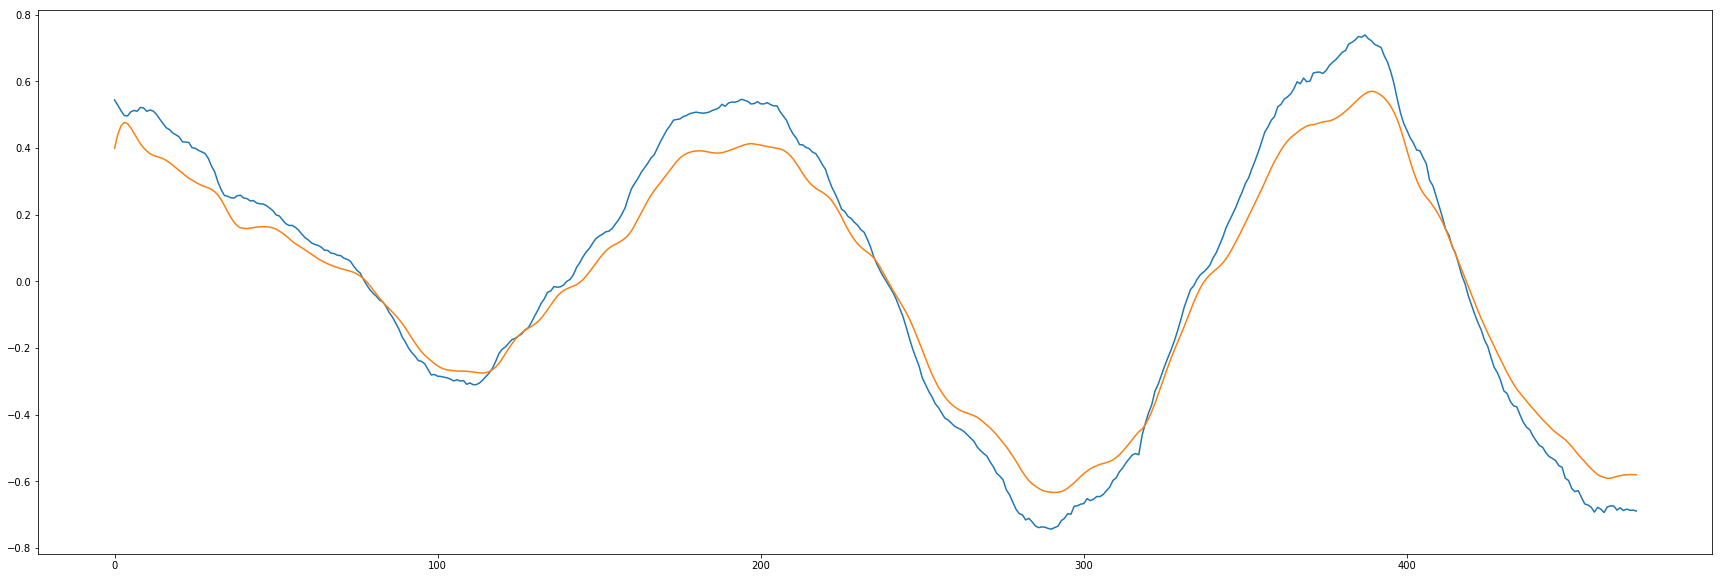

In [13]:
plt.figure(figsize=(30,10))
plt.plot(output1)

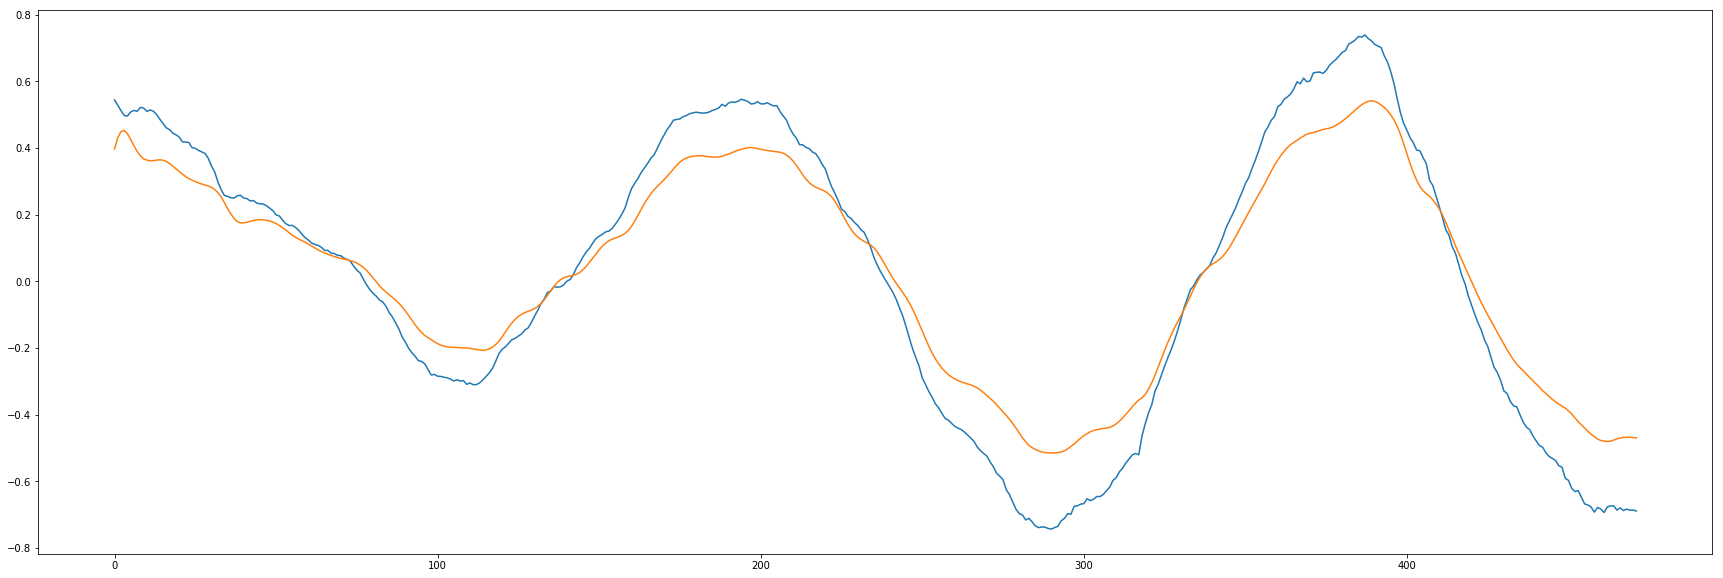

In [13]:
plt.figure(figsize=(30,10))
plt.plot(output1)